# 1. Optical Flow Guided Learning
In this Notebook we'll explore the ability of optical flow to __guide__ learning of the
SlowFast network.

First, we figure out how to read the `.jpg` encoded optical flow frames into a numpy video stream, and visualise the result.
Next, we try to find ways to extract information from the optical flow stream so we can extract a binary mask from, so it can be used in a loss function.
Lastly, we explore the application of a Dice loss, defined by $\mathcal{L}_{Dice} = 1 - (2 \cdot I) / (P + G)$, where $I$ is the __area of intersection__, $P$ the __area of prediction__, and $G$ the __ground truth area__. Here, we attempt to compare the binary mask of the GradCAM output with that of Optical Flow (**OF**), in this instance OF will act as a ground truth label.

## 1.1 Decoding Optical Flow
Our optical flow data is encoded as series of `.jpg` images. Each video has a folder, inside the flow folder on the dataset root; see format `$DATASET_PATH/flow/$VIDEO_ID/flow_${"x or y"}_$FRAME_IDX.jpg`. Optical Flow encodes the motion between frames in x and y components, as a result the there are jpgs for each frame for separate x and y components. If we want to display our video we'll have to blend th x and y components and add a third redundant channel.

In [1]:
%load_ext autoreload
%autoreload 2


import os
import torch
import cv2

import matplotlib.pyplot as plt
import diveslowlearnfast as dlf
import numpy as np

from diveslowlearnfast.datasets import Diving48Dataset
from diveslowlearnfast.config import Config

from PIL import Image


cfg = Config()
cfg.DATA.DATASET_PATH = '/Users/youritomassen/Projects/xai/data/Diving48'
diving48 = Diving48Dataset(
    cfg.DATA.DATASET_PATH,
    cfg.DATA.NUM_FRAMES,
    dataset_type='train',
    transform_fn=dlf.get_test_transform(cfg),
    use_decord=cfg.DATA_LOADER.USE_DECORD,
    temporal_random_jitter=cfg.DATA.TEMPORAL_RANDOM_JITTER,
    temporal_random_offset=cfg.DATA.TEMPORAL_RANDOM_OFFSET,
    multi_thread_decode=cfg.DATA.MULTI_THREAD_DECODE,
    threshold=cfg.DATA.THRESHOLD,
    use_sampling_ratio=cfg.DATA.USE_SAMPLING_RATIO,
)

In [2]:
video_id = 0
video_meta = diving48.data[video_id]
video_meta

{'vid_name': '-mmq0PT-u8k_00155',
 'label': 0,
 'start_frame': 0,
 'end_frame': 48}

In [3]:
# list frames for a video
video_dir = os.path.join(cfg.DATA.DATASET_PATH, 'flow', video_meta['vid_name'])
assert os.path.exists(video_dir)
assert os.path.isdir(video_dir)
frames = os.listdir(video_dir)
assert len(frames) > 0

In [4]:
frames_x = sorted(filter(lambda f: f.startswith('flow_x'), frames))
assert len(frames_x) == (video_meta['end_frame'] - video_meta['start_frame'])
frames_x[0]

'flow_x_00001.jpg'

In [5]:
direction = 'x'
for idx in range(video_meta['start_frame'], video_meta['end_frame']):
    image_path = os.path.join(video_dir, f'flow_{direction}_{idx+1:05d}.jpg')
    assert os.path.exists(image_path)



In [6]:
frame_x = cv2.imread(os.path.join(video_dir, f'flow_x_{1:05d}.jpg'), cv2.IMREAD_GRAYSCALE)
frame_x = np.array(frame_x)

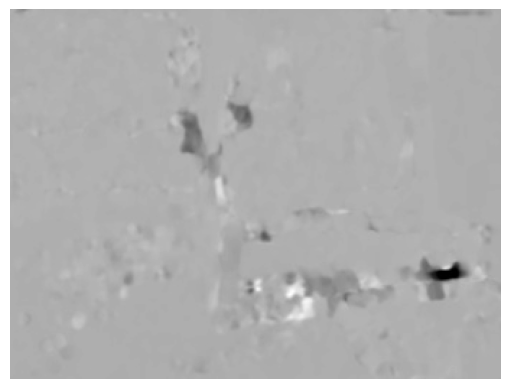

In [7]:
plt.imshow(frame_x, cmap='gray')
plt.axis('off')
plt.show()

In [8]:
frame_y = cv2.imread(os.path.join(video_dir, f'flow_y_{1:05d}.jpg'), cv2.IMREAD_GRAYSCALE)
frame_y = np.array(frame_y)

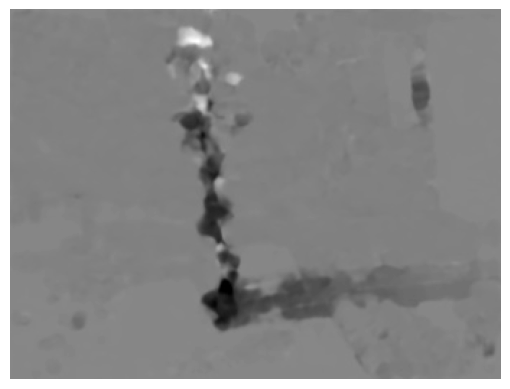

In [9]:
plt.imshow(frame_y, cmap='gray')
plt.axis('off')
plt.axis('off')
plt.show()

In [10]:
# blend OF x and y components
flow_x = (frame_x.astype(np.float32) - 128) / 128
flow_y = (frame_y.astype(np.float32) - 128) / 128

# Stack the components to create a 2-channel flow
flow = np.stack([flow_x, flow_y], axis=2)

In [11]:
rgb_flow = dlf.flow2rgb(flow)

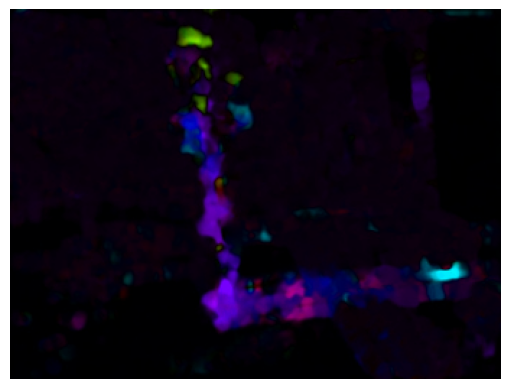

In [12]:
plt.imshow(rgb_flow)
plt.axis('off')
plt.show()

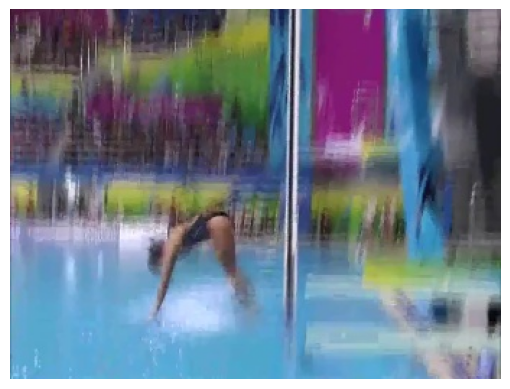

In [13]:
frame = Image.open(os.path.join(video_dir, f'img_{24:05d}.jpg'))
plt.imshow(frame)
plt.axis('off')
plt.show()

In [14]:
flow_video = dlf.read_flow(video_meta, cfg.DATA.DATASET_PATH, 'rgb')
flow_video.shape

(48, 256, 340, 3)

In [15]:
dlf.vidshow(flow_video, fps=16)

HTML(value='\n    <video width="340" height="256" controls autoplay loop>\n        <source src="data:video/mp4…

In [16]:
x, *_ = diving48[video_id]
x.max(), x.shape

(tensor(2.5806), torch.Size([3, 32, 256, 256]))

In [17]:
a = dlf.postprocess_video(x, cfg.DATA.MEAN, cfg.DATA.STD)
dlf.vidshow(a, fps=16, size=(256, 256))

HTML(value='\n    <video width="256" height="256" controls autoplay loop>\n        <source src="data:video/mp4…

## 1.2 Optical Flow Mask
In this section we'll experiment with generating a mask from optical flow frames. The goal is to create a masks from our subject the diver, since we want our model to focus on the diver. This is all fine when the camera is static, in this case the only motion that is visible on camera will be of the subject. However, when the camera moves it is not clear whether the motion is from the camera or our subject. See https://claude.ai/share/3579dde3-d92d-4ab7-a0cf-4a19cc1a38c5


In [116]:
def separate_motion_by_thresholding(flow):
    # Calculate flow magnitude
    flow_magnitude = np.sqrt(flow[..., 0]**2 + flow[..., 1]**2)

    # Estimate camera motion magnitude (using median as it's robust to outliers)
    camera_magnitude = np.median(flow_magnitude)

    # Calculate how much each pixel deviates from the camera motion
    deviation = np.abs(flow_magnitude - camera_magnitude)

    # Threshold to identify subject motion
    # The threshold could be adaptive based on the distribution of deviations
    threshold = camera_magnitude * 0.5 + np.std(deviation)
    subject_mask = deviation > threshold

    # Apply spatial consistency constraints
    subject_mask = cv2.morphologyEx(subject_mask.astype(np.uint8), cv2.MORPH_CLOSE, np.ones((5, 5)))

    # Extract subject motion
    subject_flow = flow.copy()
    subject_flow[~subject_mask] = 0

    return subject_flow, subject_mask

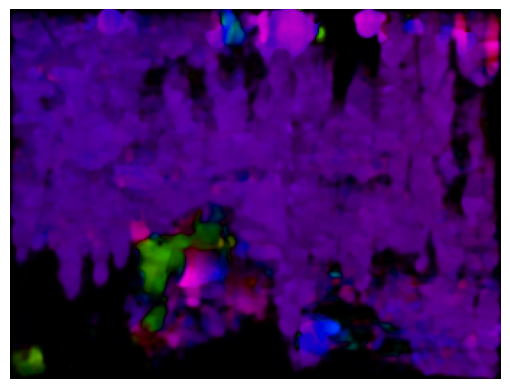

In [19]:
frame_idx = 24
flow_video = dlf.read_flow(video_meta, cfg.DATA.DATASET_PATH, modality='flow')
flow_frame = flow_video[frame_idx]
flow_frame_rgb = dlf.flow2rgb(flow_frame)
plt.imshow(flow_frame_rgb)
plt.axis('off')
plt.show()

In [20]:
flow_magnitude = np.sqrt(flow_frame[..., 0]**2 + flow_frame[..., 1]**2)
flow_magnitude.shape, flow_magnitude[0][0]

((256, 340), 0.011048543)

In [21]:
camera_magnitude = np.median(flow_magnitude)
camera_magnitude

0.61117524

In [22]:
deviation = np.abs(flow_magnitude - camera_magnitude)
deviation.shape, deviation[0][0]

((256, 340), 0.6001267)

In [23]:
threshold = camera_magnitude * .2 + np.std(deviation)
threshold

0.3241836756467819

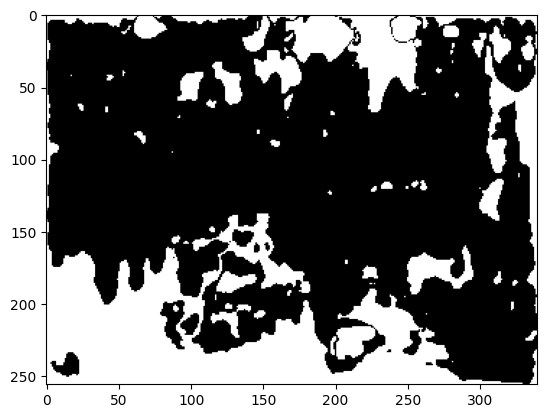

In [24]:
subject_mask = deviation > threshold
subject_mask
plt.imshow(subject_mask, cmap='gray')

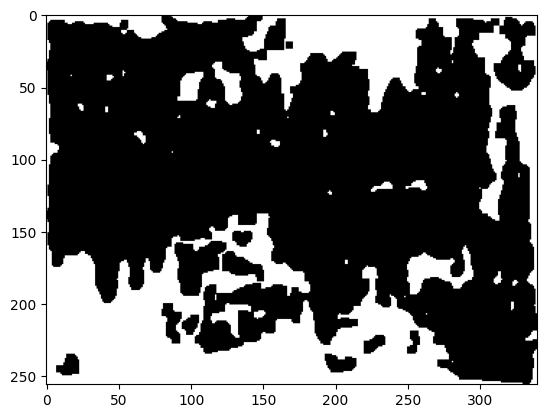

In [25]:
subject_mask = cv2.morphologyEx(subject_mask.astype(np.uint8), cv2.MORPH_CLOSE, np.ones((5, 5)))
plt.imshow(subject_mask, cmap='gray')

In [26]:
flow_video.shape

(48, 256, 340, 2)

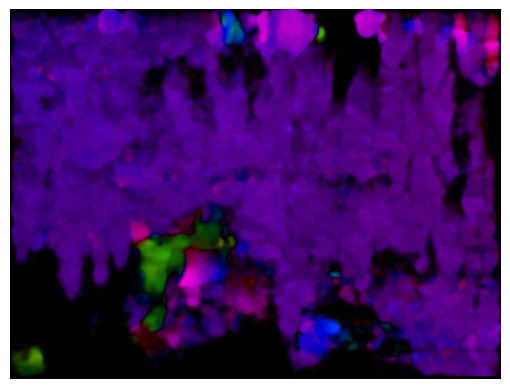

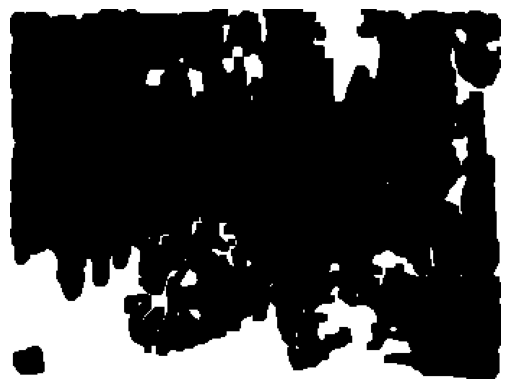

In [27]:
subject_flow, mask = separate_motion_by_thresholding(flow_frame)
subject_flow_rgb = dlf.flow2rgb(subject_flow)
plt.imshow(subject_flow_rgb)
plt.axis('off')
plt.show()

plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

In [21]:
def separate_motion_by_direction(flow):
    # Calculate flow direction angles
    flow_angles = np.arctan2(flow[..., 1], flow[..., 0])
    
    # Create histogram of angles
    hist, bins = np.histogram(flow_angles.flatten(), bins=36, range=(-np.pi, np.pi))
    
    # Find the dominant direction (camera motion)
    dominant_bin = np.argmax(hist)
    dominant_angle_min = bins[dominant_bin]
    dominant_angle_max = bins[dominant_bin + 1]
    
    # Create mask for camera motion
    angle_diff = np.minimum(
        np.abs(flow_angles - dominant_angle_min),
        np.abs(flow_angles - dominant_angle_max)
    )
    camera_mask = angle_diff < 0.2  # Threshold for angular difference
    subject_mask = ~camera_mask
    
    # Apply magnitude constraint (subject motion often stronger)
    flow_magnitude = np.sqrt(flow[..., 0]**2 + flow[..., 1]**2)
    magnitude_mask = flow_magnitude > np.median(flow_magnitude) * 1.5
    subject_mask = subject_mask | magnitude_mask
    
    # Extract subject motion
    subject_flow = flow.copy()
    subject_flow[~subject_mask] = 0
    
    return subject_flow, subject_mask

In [22]:
subject_flow, mask = separate_motion_by_direction(flow_frame)
subject_flow_rgb = dlf.flow2rgb(subject_flow)
plt.imshow(subject_flow_rgb)
plt.axis('off')
plt.show()

plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

NameError: name 'flow_frame' is not defined

In [30]:
subject_flow_video = [separate_motion_by_direction(frame)[0] for frame in flow_video]
subject_flow_video = [dlf.flow2rgb(frame) for frame in subject_flow_video]
subject_flow_video = np.stack(subject_flow_video)
subject_flow_video.shape

(48, 256, 340, 3)

In [31]:
dlf.vidshow(subject_flow_video)

HTML(value='\n    <video width="340" height="256" controls autoplay loop>\n        <source src="data:video/mp4…

In [40]:
subject_mask_video = [separate_motion_by_direction(frame)[1] for frame in flow_video]
subject_mask_video = np.float32(subject_mask_video)
subject_mask_video = [cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR) for frame in subject_mask_video]
subject_mask_video = np.stack(subject_mask_video)
subject_mask_video = np.uint8(subject_mask_video * 255)
subject_mask_video.shape

(48, 256, 340, 3)

In [41]:
# plt.imshow(subject_mask_video[9], cmap='gray')
dlf.vidshow(subject_mask_video)

HTML(value='\n    <video width="340" height="256" controls autoplay loop>\n        <source src="data:video/mp4…

In [43]:
subject_mask_video = np.stack([separate_motion_by_direction(frame)[1] for frame in flow_video])
subject_mask_video = ~subject_mask_video
subject_mask_video = np.float32(subject_mask_video)
subject_mask_video = [cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR) for frame in subject_mask_video]
subject_mask_video = np.stack(subject_mask_video)
subject_mask_video = np.uint8(subject_mask_video * 255)

dlf.vidshow(subject_mask_video)

HTML(value='\n    <video width="340" height="256" controls autoplay loop>\n        <source src="data:video/mp4…

In [34]:
def separate_motion_by_ransac(flow):
    h, w = flow.shape[:2]
    y_grid, x_grid = np.mgrid[0:h, 0:w]
    
    # Create points: original locations and their destinations according to flow
    points1 = np.column_stack([x_grid.flatten(), y_grid.flatten()])
    points2 = points1 + flow.reshape(-1, 2)
    
    # Use RANSAC to find the best affine transformation (camera motion)
    transform, inliers = cv2.estimateAffinePartial2D(
        points1.astype(np.float32), 
        points2.astype(np.float32), 
        method=cv2.RANSAC,
        ransacReprojThreshold=1.0  # Threshold for inlier classification
    )
    
    # Create masks
    camera_mask = inliers.reshape(h, w)
    subject_mask = ~camera_mask
    
    # Apply spatial consistency
    subject_mask = cv2.morphologyEx(subject_mask.astype(np.uint8), cv2.MORPH_CLOSE, np.ones((7, 7)))
    
    # Extract subject motion
    subject_flow = flow.copy()
    subject_flow[~subject_mask.astype(bool)] = 0
    
    return subject_flow, subject_mask

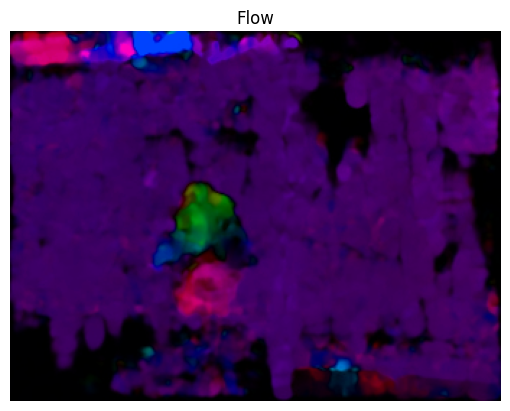

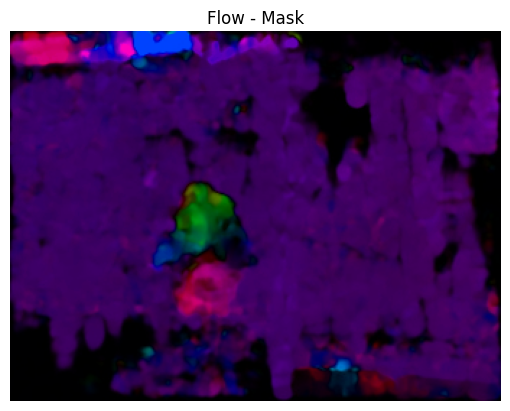

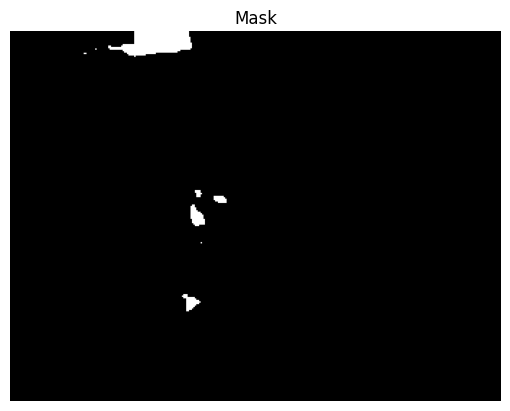

In [35]:
frame_idx = 21
flow_video = dlf.read_flow(video_meta, cfg.DATA.DATASET_PATH, modality='flow')
flow_frame = flow_video[frame_idx]
subject_flow, mask = separate_motion_by_ransac(flow_frame)
subject_flow_rgb = dlf.flow2rgb(subject_flow)
plt.imshow(dlf.flow2rgb(flow_frame))
plt.title('Flow')
plt.axis('off')
plt.show()

plt.imshow(subject_flow_rgb)
plt.title('Flow - Mask')
plt.axis('off')
plt.show()

plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')
plt.show()

In [36]:
flow_video = dlf.read_flow(video_meta, cfg.DATA.DATASET_PATH, modality='flow')
flow_subject = [separate_motion_by_ransac(frame)[0] for frame in flow_video]
flow_subject_rgb = [dlf.flow2rgb(frame) for frame in flow_subject]
flow_subject_rgb = np.stack(flow_subject_rgb)

dlf.vidshow(flow_subject_rgb)

HTML(value='\n    <video width="340" height="256" controls autoplay loop>\n        <source src="data:video/mp4…

## 1.3 Creating Optical Flow From RGB Video (TVL1)

In [74]:
video_id = 1
video_meta = diving48.data[video_id]
video_meta

{'vid_name': '-mmq0PT-u8k_00156',
 'label': 0,
 'start_frame': 0,
 'end_frame': 70}

In [75]:
x, *_ = diving48[video_id]
x = dlf.postprocess_video(x, cfg.DATA.MEAN, cfg.DATA.STD)

In [76]:
dlf.vidshow(x)

HTML(value='\n    <video width="256" height="256" controls autoplay loop>\n        <source src="data:video/mp4…

In [77]:
x_real_flow_rgb = dlf.flow(x)
x_real_flow_rgb = np.stack([dlf.flow2rgb(frame) for frame in x_real_flow_rgb])

In [78]:
dlf.vidshow(x_real_flow_rgb, size=(512, 512))

HTML(value='\n    <video width="512" height="512" controls autoplay loop>\n        <source src="data:video/mp4…

In [82]:
x_convert = dlf.rgb2flow(x_real_flow_rgb[0])

x_convert.shape, x_convert.max()

((256, 256, 2), 251.61404)

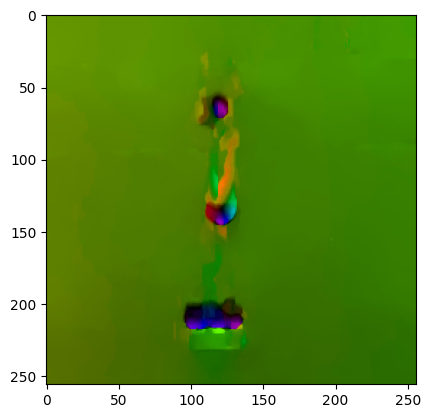

In [83]:
plt.imshow(dlf.flow2rgb(x_convert))

In [105]:
video_meta

{'vid_name': '-mmq0PT-u8k_00156',
 'label': 0,
 'start_frame': 0,
 'end_frame': 70}

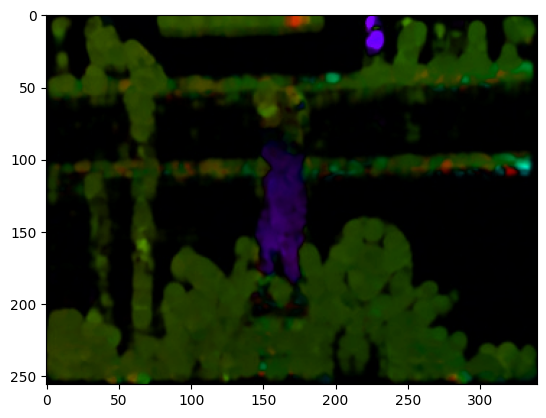

In [84]:
x_flow = dlf.read_flow(video_meta, cfg.DATA.DATASET_PATH, modality='flow')
x_flow = np.stack([dlf.flow2rgb(frame) for frame in x_flow])

plt.imshow(x_flow[4])

In [85]:
x_flow = dlf.read_flow(video_meta, cfg.DATA.DATASET_PATH, modality='flow')
x_flow = np.stack([dlf.flow2rgb(frame) for frame in x_flow])

In [86]:
dlf.vidshow(x_flow)

HTML(value='\n    <video width="340" height="256" controls autoplay loop>\n        <source src="data:video/mp4…

In [91]:
x_real_flow = np.stack([dlf.rgb2flow(flow) for flow in x_real_flow_rgb])
x_real_flow.shape

(31, 256, 256, 2)

In [92]:
subject_flow_video = [separate_motion_by_direction(frame)[0] for frame in x_real_flow]
subject_flow_video = [dlf.flow2rgb(frame) for frame in subject_flow_video]
subject_flow_video = np.stack(subject_flow_video)
subject_flow_video.shape

(31, 256, 256, 3)

In [93]:
dlf.vidshow(subject_flow_video)

HTML(value='\n    <video width="256" height="256" controls autoplay loop>\n        <source src="data:video/mp4…

In [157]:
subject_mask_video = np.stack([separate_motion_by_direction(frame)[1] for frame in x_real_flow])
subject_mask_video = subject_mask_video
subject_mask_video = dlf.bin2rgb(subject_mask_video)

dlf.vidshow(subject_mask_video, size=(420, 420))

HTML(value='\n    <video width="420" height="420" controls autoplay loop>\n        <source src="data:video/mp4…

In [158]:
mask_dir = np.stack([separate_motion_by_direction(frame)[1] for frame in x_real_flow])
mask_thresh = np.stack([separate_motion_by_thresholding(frame)[1] for frame in x_real_flow])

mask = np.logical_and(mask_dir, mask_thresh)

dlf.vidshow(subject_mask_video, size=(420, 420))

HTML(value='\n    <video width="420" height="420" controls autoplay loop>\n        <source src="data:video/mp4…

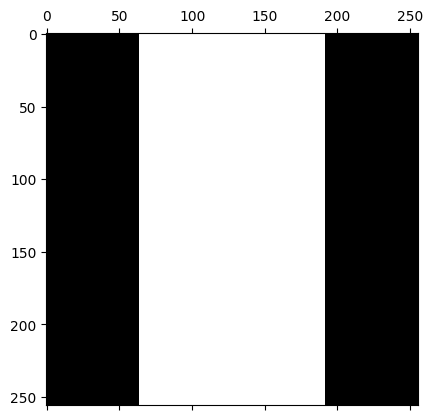

In [159]:
focal_point = np.zeros_like(mask)
_, H, W = focal_point.shape
s = W//4
focal_point[:, :, s:s*3] = 1

plt.matshow(focal_point[0], cmap='gray')

In [160]:
mask = np.logical_and(mask, focal_point)

subject_flow_video = dlf.bin2rgb(mask)
dlf.vidshow(subject_flow_video)

HTML(value='\n    <video width="256" height="256" controls autoplay loop>\n        <source src="data:video/mp4…

## 1.4 FlowNet2

In [98]:
filename = '_8Vy3dlHg2w_00000.flonet2.npy'
flo = np.load(f'data/{filename}')
flo.shape

(75, 2, 480, 640)

In [102]:
flo_rgb = flo.transpose(0, 2, 3, 1)
flo_rgb = dlf.flow2rgb(flo_rgb, mode='video') 

dlf.vidshow(flo_rgb)

HTML(value='\n    <video width="640" height="480" controls autoplay loop>\n        <source src="data:video/mp4…

In [106]:
floo = flo.transpose(0, 2, 3, 1)
subject_flow_video = [separate_motion_by_direction(frame)[0] for frame in floo]
subject_flow_video = dlf.flow2rgb(subject_flow_video, mode='video')

dlf.vidshow(subject_flow_video)

HTML(value='\n    <video width="640" height="480" controls autoplay loop>\n        <source src="data:video/mp4…

In [107]:
filename = '-mmq0PT-u8k_00144.flonet2.npy'
flo = np.load(f'data/{filename}')
flo.shape

(101, 2, 480, 640)

In [108]:
flo_rgb = flo.transpose(0, 2, 3, 1)
flo_rgb = dlf.flow2rgb(flo_rgb, mode='video') 

dlf.vidshow(flo_rgb)

HTML(value='\n    <video width="640" height="480" controls autoplay loop>\n        <source src="data:video/mp4…

In [109]:
floo = flo.transpose(0, 2, 3, 1)
subject_flow_video = [separate_motion_by_direction(frame)[0] for frame in floo]
subject_flow_video = dlf.flow2rgb(subject_flow_video, mode='video')

dlf.vidshow(subject_flow_video)

HTML(value='\n    <video width="640" height="480" controls autoplay loop>\n        <source src="data:video/mp4…

In [114]:
subject_mask_video = [separate_motion_by_direction(frame)[1] for frame in floo]

subject_flow_video = dlf.bin2rgb(subject_mask_video)

dlf.vidshow(subject_flow_video)

HTML(value='\n    <video width="640" height="480" controls autoplay loop>\n        <source src="data:video/mp4…

In [129]:
filename = '_8Vy3dlHg2w_00001.flonet2.npy'
flo = np.load(f'data/{filename}')
flo.shape

(87, 2, 480, 640)

In [130]:
flo_rgb = flo.transpose(0, 2, 3, 1)
flo_rgb = dlf.flow2rgb(flo_rgb, mode='video') 

dlf.vidshow(flo_rgb)

HTML(value='\n    <video width="640" height="480" controls autoplay loop>\n        <source src="data:video/mp4…

In [131]:
subject_mask_video = [separate_motion_by_direction(frame)[1] for frame in flo_rgb]

subject_flow_video = dlf.bin2rgb(subject_mask_video)

dlf.vidshow(subject_flow_video)

HTML(value='\n    <video width="640" height="480" controls autoplay loop>\n        <source src="data:video/mp4…

In [132]:
subject_mask_video = [separate_motion_by_thresholding(frame)[1] for frame in flo_rgb]

subject_flow_video = dlf.bin2rgb(subject_mask_video)

dlf.vidshow(subject_flow_video)

HTML(value='\n    <video width="640" height="480" controls autoplay loop>\n        <source src="data:video/mp4…

### 1.4.1 `separate_motion_by_thresholding`

In [117]:
subject_mask_video = [separate_motion_by_thresholding(frame)[1] for frame in floo]

subject_flow_video = dlf.bin2rgb(subject_mask_video)

dlf.vidshow(subject_flow_video)

HTML(value='\n    <video width="640" height="480" controls autoplay loop>\n        <source src="data:video/mp4…

### 1.4.2 Combining Multiple Algorithms

In [119]:
mask_dir = np.stack([separate_motion_by_direction(frame)[1] for frame in floo])
mask_thresh = np.stack([separate_motion_by_thresholding(frame)[1] for frame in floo])

mask = np.logical_and(mask_dir, mask_thresh)

subject_flow_video = dlf.bin2rgb(mask)
dlf.vidshow(subject_flow_video)

HTML(value='\n    <video width="640" height="480" controls autoplay loop>\n        <source src="data:video/mp4…

In [120]:
filename = '_8Vy3dlHg2w_00000.flonet2.npy'
flo = np.load(f'data/{filename}')
flo.shape

(75, 2, 480, 640)

In [122]:
floo = flo.transpose(0, 2, 3, 1)

In [123]:
mask_dir = np.stack([separate_motion_by_direction(frame)[1] for frame in floo])
mask_thresh = np.stack([separate_motion_by_thresholding(frame)[1] for frame in floo])

mask = np.logical_and(mask_dir, mask_thresh)

subject_flow_video = dlf.bin2rgb(mask)
dlf.vidshow(subject_flow_video)

HTML(value='\n    <video width="640" height="480" controls autoplay loop>\n        <source src="data:video/mp4…

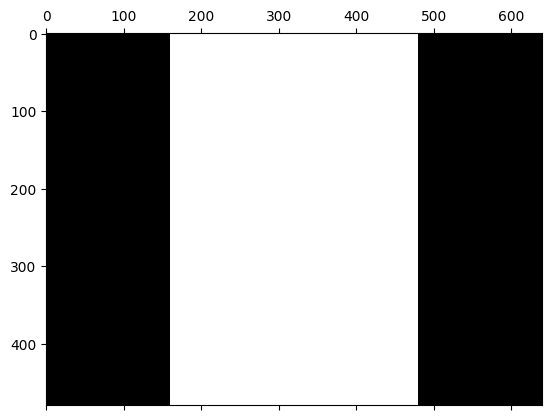

In [151]:
focal_point = np.zeros_like(mask)
_, H, W = focal_point.shape
s = W//4
focal_point[:, :, s:s*3] = 1

plt.matshow(focal_point[0], cmap='gray')

In [152]:
mask = np.logical_and(mask, focal_point)

subject_flow_video = dlf.bin2rgb(mask)
dlf.vidshow(subject_flow_video)

HTML(value='\n    <video width="640" height="480" controls autoplay loop>\n        <source src="data:video/mp4…

In [153]:
mask_dir = np.stack([separate_motion_by_direction(frame)[1] for frame in floo])
mask = np.logical_and(mask_dir, focal_point)

subject_flow_video = dlf.bin2rgb(mask)
dlf.vidshow(subject_flow_video)

HTML(value='\n    <video width="640" height="480" controls autoplay loop>\n        <source src="data:video/mp4…

# 2. Side Quest: can we reduce the number of frames loaded

In [7]:
video_idx = 22
video_meta = diving48.data[video_idx]
video_meta

{'vid_name': 'D8YKHC5hmUs_00128',
 'label': 0,
 'start_frame': 0,
 'end_frame': 73}

In [21]:
video_idx = 1
video_meta = diving48.data[video_idx]
video_dir = os.path.join(cfg.DATA.DATASET_PATH, 'flow', video_meta['vid_name'])
len(os.listdir(video_dir))

210

In [22]:
import av

In [28]:
video_idx = 2
video_meta = diving48.data[video_idx]
video_path = os.path.join(cfg.DATA.DATASET_PATH, 'rgb', f'{video_meta['vid_name']}.mp4')
assert os.path.exists(video_path)
container = av.open(video_path)
container.streams.video[0].thread_type = 'AUTO'
video_stream = container.streams.video[0]
total_frames = video_stream.frames

total_frames, (video_meta['end_frame'] - video_meta['start_frame'] + 1)

(91, 90, 90, 0)

In [29]:
for video_meta in diving48.data:
    video_path = os.path.join(cfg.DATA.DATASET_PATH, 'rgb', f'{video_meta['vid_name']}.mp4')
    assert os.path.exists(video_path)
    container = av.open(video_path)
    container.streams.video[0].thread_type = 'AUTO'
    video_stream = container.streams.video[0]
    total_frames = video_stream.frames
    total_meta_frames = video_meta['end_frame'] - video_meta['start_frame'] + 1
    if total_frames != total_meta_frames:
        print(f'{total_frames} != {total_meta_frames}')